In [1]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [2]:
target_gu = '송파구'
target_dong = '오금동'
#target_purpose = '준주거'
target_building_age = 3
target_period = 36 # in months

In [3]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [4]:
date_today_record = str(date_today).split(' ')[0].replace('-', '')
date_today_record

'20210618'

In [5]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [6]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [7]:
def data_prep(bdtype, tradetype):
    # bdtype is a string: one of 아파트, 연립다세대 or 오피스텔
    # tradetype is a string: one of 매매 or 전월세
    
    basedir = './국토교통부_실거래가_공개시스템/{}/{}/'.format(bdtype, tradetype)
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm(enumerate(filenames)):
        df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])

        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약날짜기준_건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
        
    cols_to_drop = ['시군구', '번지', '본번', '부번', '지번주소', '계약년월', '계약일', '도로명']
        
    concat_df = concat_df[['지번주소', '도로명'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    concat_df['건물연식'] = date_today.year - concat_df['건축년도']
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    if '건물명' in concat_df.columns:
        concat_df.rename(columns={'건물명':'건물(단지)명'}, inplace=True)
    elif '단지명' in concat_df.columns:
        concat_df.rename(columns={'단지명':'건물(단지)명'}, inplace=True)
    
    concat_df = concat_df[concat_df['층'] >= 0].reset_index(drop=True)
    
    return concat_df

In [8]:
yunrip_df = data_prep('연립다세대', '매매')
yunrip_df['부동산유형'] = '연립다세대'
print(yunrip_df.shape)
yunrip_df.head()

16it [00:01, 10.70it/s]


(638092, 13)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 171-13,선릉로14길 11,(171-13),68.08,56.10,56500,2,1988.0,18.0,2006-12-20,829.905993,33.0,연립다세대
1,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,40500,2,1988.0,18.0,2006-12-09,770.108386,33.0,연립다세대
2,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,42000,1,1988.0,18.0,2006-12-19,798.630918,33.0,연립다세대
3,서울특별시 강남구 개포동 1239-6,개포로15길 27,강남빌라 나동,52.75,44.68,22000,2,1988.0,18.0,2006-11-02,417.061611,33.0,연립다세대
4,서울특별시 강남구 개포동 1175-2,논현로6길 36-8,강남파크,49.43,23.70,17000,4,1993.0,13.0,2006-07-19,343.920696,28.0,연립다세대


In [9]:
officetel_df = data_prep('오피스텔', '매매')
officetel_df['부동산유형'] = '오피스텔'
print(officetel_df.shape)
officetel_df.head()

16it [00:00, 40.81it/s]


(181388, 12)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,6400,8,1997.0,9.0,2006-01-10,197.287300,24.0,오피스텔
1,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7100,7,1997.0,9.0,2006-01-10,218.865598,24.0,오피스텔
2,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7300,11,1997.0,9.0,2006-01-11,225.030826,24.0,오피스텔
3,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,31.91,7500,10,1997.0,9.0,2006-01-18,235.036039,24.0,오피스텔
4,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7400,15,1997.0,9.0,2006-01-19,228.113440,24.0,오피스텔


In [10]:
yunrip_df = yunrip_df.drop(columns=['대지권면적(㎡)'])
house_df = pd.concat([yunrip_df, officetel_df]).sort_values(['지번주소', '건축년도', '전용면적(㎡)', '계약날짜']).reset_index(drop=True)
print(house_df.shape)
house_df.head()

(819480, 12)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 1164-0,논현로2길 6,골드캐슬,58.05,57500,2,2017.0,1.0,2018-01-20,990.525409,4.0,연립다세대
1,서울특별시 강남구 개포동 1164-0,논현로2길 6,골드캐슬,58.05,57000,1,2017.0,1.0,2018-06-01,981.912145,4.0,연립다세대
2,서울특별시 강남구 개포동 1164-0,논현로2길 6,골드캐슬,58.05,63000,2,2017.0,2.0,2019-01-19,1085.271318,4.0,연립다세대
3,서울특별시 강남구 개포동 1164-26,논현로2길 64,슈베르트빌,34.47,31000,4,2015.0,1.0,2016-03-01,899.332753,6.0,연립다세대
4,서울특별시 강남구 개포동 1164-26,논현로2길 64,슈베르트빌,34.47,30000,3,2015.0,1.0,2016-03-20,870.322019,6.0,연립다세대


In [11]:
'''land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')
print(land_specs_df.shape)
land_specs_df.head()'''

"land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')\nprint(land_specs_df.shape)\nland_specs_df.head()"

In [12]:
'''last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)
print(last_df.shape)
last_df.head()'''

"last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)\nprint(last_df.shape)\nlast_df.head()"

In [13]:
'''house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)
print(house_merge_df.shape)'''

"house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)\nprint(house_merge_df.shape)"

In [14]:
house_df['구'] = house_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_df['동'] = house_df['지번주소'].apply(lambda x: x.split(' ')[2])
#house_merge_df['구'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[1])
#house_merge_df['동'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [15]:
target_df = house_df[
    (house_df['구'] == target_gu)
    &(house_df['동'] == target_dong)
    &(house_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df.shape)
target_df.head()

(402, 14)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동
586768,서울특별시 송파구 오금동 10-0,위례성대로22나길 21,아미하우스,42.70,65000,6,2019.0,1.0,2020-04-03,1522.248244,2.0,연립다세대,송파구,오금동
586769,서울특별시 송파구 오금동 10-0,위례성대로22나길 21,아미하우스,43.06,45000,4,2019.0,0.0,2019-12-24,1045.053414,2.0,연립다세대,송파구,오금동
586770,서울특별시 송파구 오금동 10-0,위례성대로22나길 21,아미하우스,43.06,45900,2,2019.0,1.0,2020-01-27,1065.954482,2.0,연립다세대,송파구,오금동
586771,서울특별시 송파구 오금동 10-0,위례성대로22나길 21,아미하우스,43.18,45500,3,2019.0,1.0,2020-01-02,1053.728578,2.0,연립다세대,송파구,오금동
586772,서울특별시 송파구 오금동 10-0,위례성대로22나길 21,아미하우스,43.18,45900,2,2019.0,1.0,2020-01-21,1062.992126,2.0,연립다세대,송파구,오금동


In [16]:
sales_idx_basedir = './한국부동산원/실거래가격지수/'
filenames = [f for f in os.listdir(sales_idx_basedir) if '연립다세대' in f]

sales_idx_df = pd.read_excel(sales_idx_basedir + filenames[0], header=[10, 11])

sales_idx_cols_list = []
for i in range(sales_idx_df.shape[1]):
    if i == 0:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0])
    else:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0] + '_' + sales_idx_df.columns[i][1])

sales_idx_df.columns = sales_idx_cols_list

In [17]:
def get_sales_idx(x):
    # x is a pandas timestamp
    
    df = sales_idx_df.copy()
    
    if pd.isna(x) == True:
        return x
    else:
        year = str(x.year)
        month = str(x.month)
        if len(month) == 1:
            month = '0'+month
        
        idx = df[year+'년 '+month+'월_지수'].iloc[0]
        
        return idx

In [18]:
def get_index_applied_prices(df):
    df = df.copy()
    
    last_idx = sales_idx_df.iloc[0,-2]
    
    last_date = sales_idx_df.columns[-1].split('_')[0]
    
    last_date = last_date.split(' ')[0].replace('년','') + '-' + last_date.split(' ')[1].replace('월','') + '-01'
    
    target_upper_limit_df = df[df['계약날짜'] < pd.to_datetime(last_date)]
    target_upper_limit_df['계약날짜_실거래지수'] = target_upper_limit_df['계약날짜'].apply(get_sales_idx)
    target_upper_limit_df['지수적용단가'] = target_upper_limit_df['단가(만원/㎡)'] / target_upper_limit_df['계약날짜_실거래지수'] * last_idx
    df['지수적용단가'] = df['단가(만원/㎡)']
    df.loc[target_upper_limit_df.index, '지수적용단가'] = target_upper_limit_df['지수적용단가']
    df['평가날짜'] = df['계약날짜']
    df.loc[target_upper_limit_df.index, '평가날짜'] = pd.to_datetime(last_date[:-2] + '01')
    
    return df

In [19]:
target_df = get_index_applied_prices(target_df)
print(target_df.shape)
target_df.head()

(402, 16)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,지수적용단가,평가날짜
586768,서울특별시 송파구 오금동 10-0,위례성대로22나길 21,아미하우스,42.70,65000,6,2019.0,1.0,2020-04-03,1522.248244,2.0,연립다세대,송파구,오금동,1754.153088,2021-04-01
586769,서울특별시 송파구 오금동 10-0,위례성대로22나길 21,아미하우스,43.06,45000,4,2019.0,0.0,2019-12-24,1045.053414,2.0,연립다세대,송파구,오금동,1202.407061,2021-04-01
586770,서울특별시 송파구 오금동 10-0,위례성대로22나길 21,아미하우스,43.06,45900,2,2019.0,1.0,2020-01-27,1065.954482,2.0,연립다세대,송파구,오금동,1232.346525,2021-04-01
586771,서울특별시 송파구 오금동 10-0,위례성대로22나길 21,아미하우스,43.18,45500,3,2019.0,1.0,2020-01-02,1053.728578,2.0,연립다세대,송파구,오금동,1218.212197,2021-04-01
586772,서울특별시 송파구 오금동 10-0,위례성대로22나길 21,아미하우스,43.18,45900,2,2019.0,1.0,2020-01-21,1062.992126,2.0,연립다세대,송파구,오금동,1228.921755,2021-04-01


In [20]:
target_df = target_df.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df1 = target_df[['지번주소', '건물(단지)명', '건물연식', '층', '전용면적(㎡)', '계약날짜', '거래금액(만원)', '단가(만원/㎡)', '평가날짜', '지수적용단가', '부동산유형']]
target_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/실거래가.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [21]:
target_df1.head()

,지번주소,건물(단지)명,건물연식,층,전용면적(㎡),계약날짜,거래금액(만원),단가(만원/㎡),평가날짜,지수적용단가,부동산유형
0,서울특별시 송파구 오금동 10-0,아미하우스,2.0,4,43.06,2019-12-24,45000,1045.053414,2021-04-01,1202.407061,연립다세대
1,서울특별시 송파구 오금동 10-0,아미하우스,2.0,3,43.18,2020-01-02,45500,1053.728578,2021-04-01,1218.212197,연립다세대
2,서울특별시 송파구 오금동 10-0,아미하우스,2.0,2,43.18,2020-01-21,45900,1062.992126,2021-04-01,1228.921755,연립다세대
3,서울특별시 송파구 오금동 10-0,아미하우스,2.0,2,43.06,2020-01-27,45900,1065.954482,2021-04-01,1232.346525,연립다세대
4,서울특별시 송파구 오금동 10-0,아미하우스,2.0,6,42.70,2020-04-03,65000,1522.248244,2021-04-01,1754.153088,연립다세대


In [22]:
target_df1_30 = target_df1[
    (target_df1['전용면적(㎡)'] >= 28)
    &(target_df1['전용면적(㎡)'] <= 32)
]

In [23]:
target_df1_30.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/실거래가_30.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

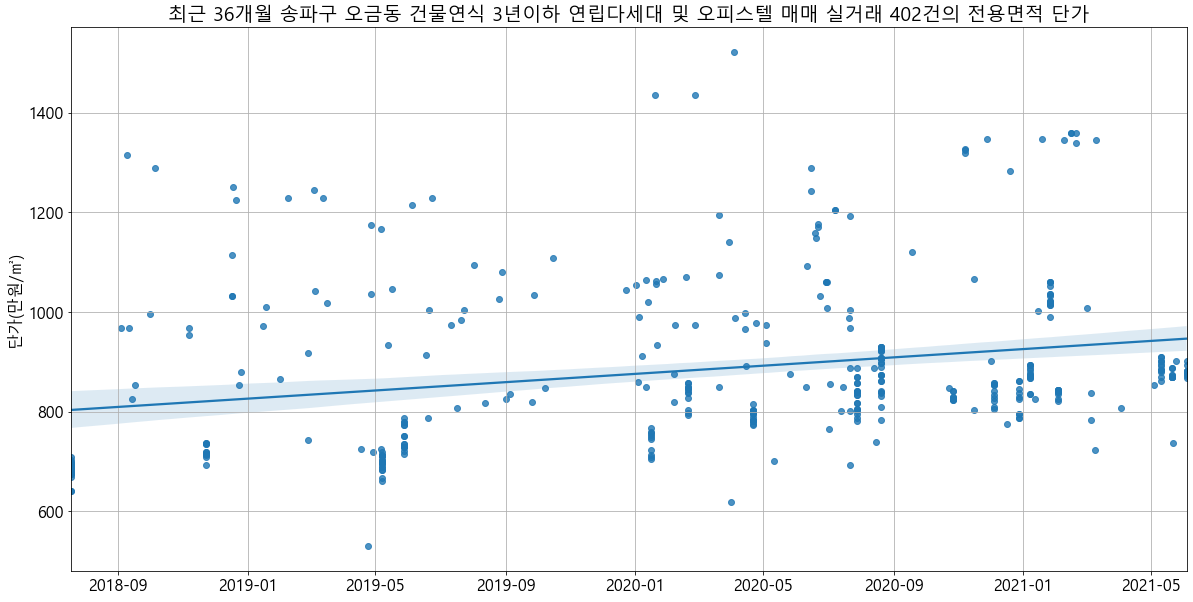

In [24]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df['계약날짜']), y=target_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/산포도.png'.format(target_gu, target_dong, date_today_record))

In [25]:
target_last_df = target_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last').reset_index(drop=True)

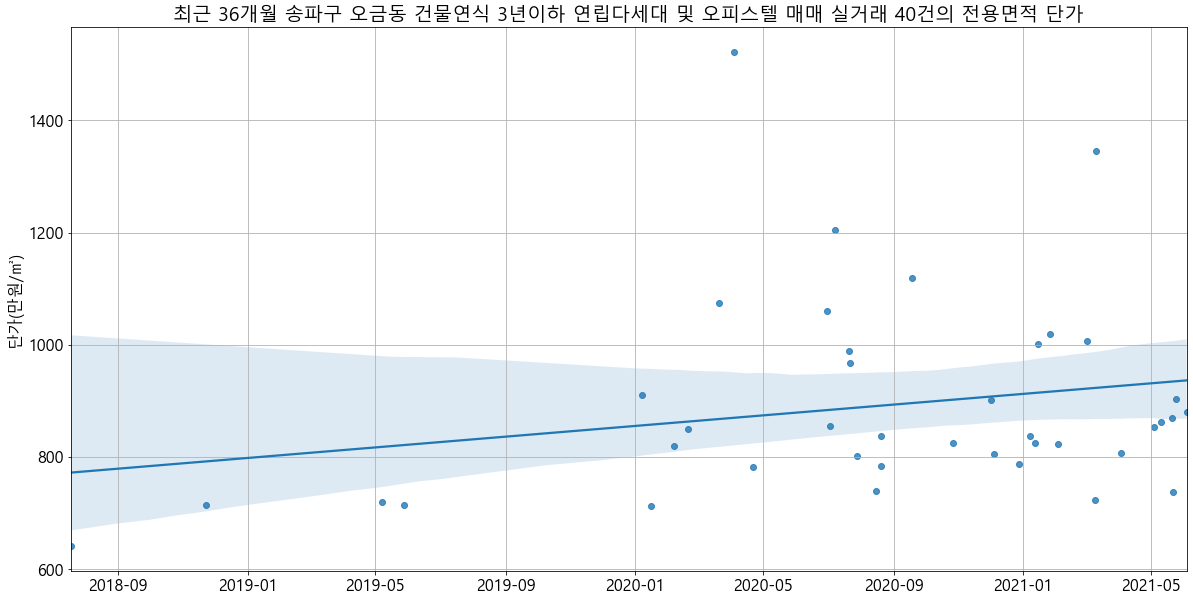

In [26]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_last_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_last_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_last_df['계약날짜']), y=target_last_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/마지막_산포도.png'.format(target_gu, target_dong, date_today_record))

In [27]:
target_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/마지막_실거래가.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [28]:
target_df2 = house_df[
    (house_df['구'] == target_gu)
    &(house_df['동'] == target_dong)
    #&(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_df['계약날짜기준_건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df2.shape)
target_df2.head()

(1323, 14)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동
586768,서울특별시 송파구 오금동 10-0,위례성대로22나길 21,아미하우스,42.70,65000,6,2019.0,1.0,2020-04-03,1522.248244,2.0,연립다세대,송파구,오금동
586769,서울특별시 송파구 오금동 10-0,위례성대로22나길 21,아미하우스,43.06,45000,4,2019.0,0.0,2019-12-24,1045.053414,2.0,연립다세대,송파구,오금동
586770,서울특별시 송파구 오금동 10-0,위례성대로22나길 21,아미하우스,43.06,45900,2,2019.0,1.0,2020-01-27,1065.954482,2.0,연립다세대,송파구,오금동
586771,서울특별시 송파구 오금동 10-0,위례성대로22나길 21,아미하우스,43.18,45500,3,2019.0,1.0,2020-01-02,1053.728578,2.0,연립다세대,송파구,오금동
586772,서울특별시 송파구 오금동 10-0,위례성대로22나길 21,아미하우스,43.18,45900,2,2019.0,1.0,2020-01-21,1062.992126,2.0,연립다세대,송파구,오금동


In [29]:
target_df2 = get_index_applied_prices(target_df2)

<AxesSubplot:title={'center':'송파구 오금동 계약날짜기준 건물연식 3년이하 연립다세대 및 오피스텔 매매 실거래 1323건의 전용면적 단가'}, xlabel='단가(만원/㎡)', ylabel='Count'>

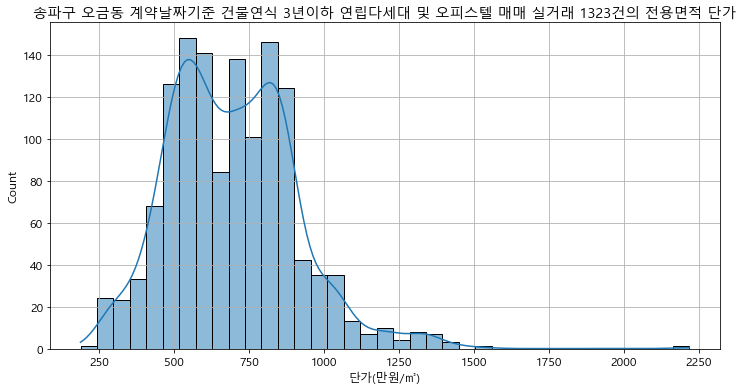

In [30]:
font = {'size': 12}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(12,6))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 {}건의 전용면적 단가'.format(target_gu, target_dong, target_building_age, target_df2.shape[0]))
plt.grid(True)
sns.histplot(target_df2['단가(만원/㎡)'], kde=True)

In [31]:
target_df3 = target_df2[['지번주소', '건물(단지)명', '건축년도', '층', '전용면적(㎡)', '계약날짜', '단가(만원/㎡)', '평가날짜', '지수적용단가', '부동산유형']]
target_df3 = target_df3.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df3.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/지수적용_실거래가.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [32]:
target_df3_30 = target_df3[
    (target_df3['전용면적(㎡)'] >= 28)
    &(target_df3['전용면적(㎡)'] <= 32)
]

In [33]:
target_df3_30.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/지수적용_실거래가_30.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [34]:
concat_df = pd.concat([target_df2])

In [35]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '전용면적(㎡)', '계약날짜']).reset_index(drop=True)
concat_df = concat_df.drop_duplicates(['지번주소', '건축년도', '전용면적(㎡)'], keep='last').reset_index(drop=True)

In [36]:
concat_df['단가평균'] = concat_df[['지번주소', '건축년도', '단가(만원/㎡)']].groupby(['지번주소', '건축년도']).transform('mean')['단가(만원/㎡)']
concat_df['지수적용단가평균'] = concat_df[['지번주소', '건축년도', '지수적용단가']].groupby(['지번주소', '건축년도']).transform('mean')['지수적용단가']

In [37]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '평가날짜']).reset_index(drop=True)
print(concat_df.shape)
concat_df.head()

(689, 18)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
0,서울특별시 송파구 오금동 10-0,위례성대로22나길 21,아미하우스,42.70,65000,6,2019.0,1.0,2020-04-03,1522.248244,2.0,연립다세대,송파구,오금동,1754.153088,2021-04-01,1217.064951,1405.140456
1,서울특별시 송파구 오금동 10-0,위례성대로22나길 21,아미하우스,43.06,45900,2,2019.0,1.0,2020-01-27,1065.954482,2.0,연립다세대,송파구,오금동,1232.346525,2021-04-01,1217.064951,1405.140456
2,서울특별시 송파구 오금동 10-0,위례성대로22나길 21,아미하우스,43.18,45900,2,2019.0,1.0,2020-01-21,1062.992126,2.0,연립다세대,송파구,오금동,1228.921755,2021-04-01,1217.064951,1405.140456
3,서울특별시 송파구 오금동 112-2,문정로25길 5,명동빌리지,27.48,19450,5,2013.0,1.0,2014-02-22,707.787482,8.0,연립다세대,송파구,오금동,1050.484225,2021-04-01,643.200885,957.871493
4,서울특별시 송파구 오금동 112-2,문정로25길 5,명동빌리지,35.81,25000,4,2013.0,1.0,2014-01-10,698.129014,8.0,연립다세대,송파구,오금동,1045.921891,2021-04-01,643.200885,957.871493


In [38]:
concat_last_df = concat_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last')
print(concat_last_df.shape)
concat_last_df

(187, 18)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
2,서울특별시 송파구 오금동 10-0,위례성대로22나길 21,아미하우스,43.180,45900,2,2019.0,1.0,2020-01-21,1062.992126,2.0,연립다세대,송파구,오금동,1228.921755,2021-04-01,1217.064951,1405.140456
5,서울특별시 송파구 오금동 112-2,문정로25길 5,명동빌리지,54.040,28300,2,2013.0,1.0,2014-08-16,523.686158,8.0,연립다세대,송파구,오금동,777.208361,2021-04-01,643.200885,957.871493
8,서울특별시 송파구 오금동 112-4,문정로 267,랜드파크빌,42.920,24000,6,2014.0,3.0,2017-07-20,559.179870,7.0,연립다세대,송파구,오금동,710.148711,2021-04-01,690.129044,909.340532
12,서울특별시 송파구 오금동 112-5,문정로 265,대성에코빌,38.400,29800,5,2015.0,3.0,2018-09-10,776.041667,6.0,연립다세대,송파구,오금동,926.695173,2021-04-01,858.235206,1112.213213
14,서울특별시 송파구 오금동 113-8,마천로 205-8,정명캐슬,63.060,30000,7,2013.0,0.0,2013-02-28,475.737393,8.0,연립다세대,송파구,오금동,710.753611,2021-04-01,469.905822,693.564463
16,서울특별시 송파구 오금동 114-10,문정로23길 13,베아타빌,69.370,21500,5,2004.0,2.0,2006-09-29,309.932247,17.0,연립다세대,송파구,오금동,663.856193,2021-04-01,330.805897,634.979481
17,서울특별시 송파구 오금동 114-11,문정로23길 11,한흥빌라(114-11),49.380,14500,3,2004.0,2.0,2006-03-11,293.641150,17.0,연립다세대,송파구,오금동,721.956361,2021-04-01,293.641150,721.956361
18,서울특별시 송파구 오금동 114-12,문정로23길 9-1,삼성쉐르빌,39.910,12200,5,2003.0,3.0,2006-09-30,305.687798,18.0,연립다세대,송파구,오금동,654.764837,2021-04-01,305.687798,654.764837
21,서울특별시 송파구 오금동 114-2,마천로 195-18,씨티빌,59.700,14900,2,2004.0,2.0,2006-10-23,249.581240,17.0,연립다세대,송파구,오금동,509.306364,2021-04-01,279.839359,553.278114
23,서울특별시 송파구 오금동 114-26,마천로 195-6,두일그린빌(114-26),62.390,22500,5,2008.0,0.0,2008-10-22,360.634717,13.0,연립다세대,송파구,오금동,498.654878,2021-04-01,371.341716,510.324367


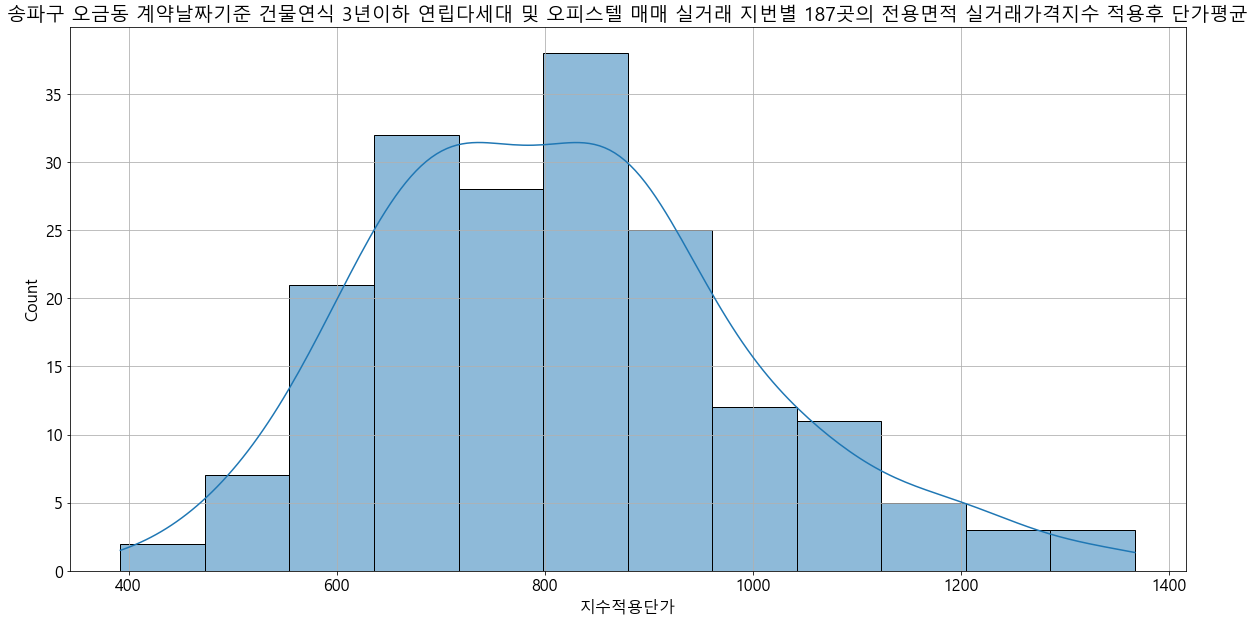

In [39]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 지번별 {}곳의 전용면적 실거래가격지수 적용후 단가평균'.format(target_gu, target_dong, target_building_age, concat_last_df.shape[0]))
plt.grid(True)
sns.histplot(concat_last_df['지수적용단가'], kde=True)
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/지번별_분포도.png'.format(target_gu, target_dong, date_today_record))

In [40]:
concat_last_df = concat_last_df.sort_values(['지번주소']).reset_index(drop=True)

In [41]:
concat_last_df = concat_last_df[['지번주소', '건물(단지)명', '건축년도', '전용면적(㎡)', '층', '계약날짜', '단가(만원/㎡)', '평가날짜', '지수적용단가', '부동산유형']]
concat_last_df.rename(columns={'계약날짜':'마지막_계약날짜'}, inplace=True)
concat_last_df.head()

,지번주소,건물(단지)명,건축년도,전용면적(㎡),층,마지막_계약날짜,단가(만원/㎡),평가날짜,지수적용단가,부동산유형
0,서울특별시 송파구 오금동 10-0,아미하우스,2019.0,43.18,2,2020-01-21,1062.992126,2021-04-01,1228.921755,연립다세대
1,서울특별시 송파구 오금동 112-2,명동빌리지,2013.0,54.04,2,2014-08-16,523.686158,2021-04-01,777.208361,연립다세대
2,서울특별시 송파구 오금동 112-4,랜드파크빌,2014.0,42.92,6,2017-07-20,559.179870,2021-04-01,710.148711,연립다세대
3,서울특별시 송파구 오금동 112-5,대성에코빌,2015.0,38.40,5,2018-09-10,776.041667,2021-04-01,926.695173,연립다세대
4,서울특별시 송파구 오금동 113-8,정명캐슬,2013.0,63.06,7,2013-02-28,475.737393,2021-04-01,710.753611,연립다세대


In [42]:
concat_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/지수적용_마지막_실거래가.xlsx'.format(target_gu, target_dong, date_today_record), index=False)